# Chapter 4 Prepare Data for Modeling

>All data is dirty, irrespective of what the source of the data might lead you to believe:

Your data can be stained with duplicates, missing observations and outliers, nonexistent addresses, wrong phone numbers and area codes, inaccurate geographical coordinates, wrong dates, incorrect labels, mixtures of upper and lower cases, trailing spaces, and many other more subtle problems.

In this chapter, you will learn how to do the following:

- Recognize and handle duplicates, missing observations, and outliers
- Calculate descriptive statistics and correlations
- Visualize your data with matplotlib and Bokeh

## Checking for duplicates, missing observations, and outliers

Until you have fully tested the data and proven it worthy of your time, you should neither trust it nor use it.

### Duplicates

Duplicates are observations that appear as distinct rows in your dataset, but which, upon closer inspection, look the same.

On the other hand, if your data has some form of an ID to distinguish between records (or associate them with certain users, for example), then what might initially appear as a duplicate may not be; sometimes systems fail and produce erroneous IDs. In such a situation, you need to either check whether the same ID is a real duplicate, or you need to come up with a new ID system.

Consider the following example, 

In [1]:
from pyspark import SparkContext , SparkConf
conf = SparkConf().setAppName('chapter4')
sc = SparkContext(conf=conf)
sc

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Chapter4") \
    .getOrCreate()

In [2]:
df = spark.createDataFrame([
        (1, 144.5, 5.9, 33, 'M'),
        (2, 167.2, 5.4, 45, 'M'),
        (3, 124.1, 5.2, 23, 'F'),
        (4, 144.5, 5.9, 33, 'M'),
        (5, 133.2, 5.7, 54, 'F'),
        (3, 124.1, 5.2, 23, 'F'),
        (5, 129.2, 5.3, 42, 'M'),
    ], ['id', 'weight', 'height', 'age', 'gender'])

In [3]:
print('Count of rows: {0}'.format(df.count()))
print('Count of distinct rows: {0}'.format(df.distinct().count()))

Count of rows: 7
Count of distinct rows: 6


We can drop these rows by using the `.dropDuplicates(...)` method:

In [4]:
df = df.dropDuplicates()
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
|  1| 144.5|   5.9| 33|     M|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



In [5]:
print('Count of ids: {0}'.format(df.count()))
print('Count of distinct ids: {0}'.format(df.select([c for c in df.columns if c != 'id']).distinct().count()))

Count of ids: 6
Count of distinct ids: 5


We can still use the `.dropDuplicates(...)`, but will add the `subset` parameter that specifies only the columns other than the id column:

In [6]:
df = df.dropDuplicates(subset=[c for c in df.columns if c != 'id'])
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



The subset parameter instructs the `.dropDuplicates(...)` method to look for duplicated rows using only the columns specified via the subset parameter

To calculate the total and distinct number of IDs in one step, we can use the `.agg(...)` method:

In [7]:
import pyspark.sql.functions as fn

df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
).show()

+-----+--------+
|count|distinct|
+-----+--------+
|    5|       4|
+-----+--------+



Next, we use the `.count(...)` and `.countDistinct(...)` to, respectively, calculate the number of rows and the number of distinct ids in our DataFrame. The `.alias(...)` method allows us to specify a friendly name to the returned column.
Since we have already dropped all the duplicates, we can safely assume that this might just be a fluke in our ID data, so we will give each row a unique ID:

In [8]:
df.withColumn('new_id', fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-------------+
| id|weight|height|age|gender|       new_id|
+---+------+------+---+------+-------------+
|  5| 133.2|   5.7| 54|     F|  25769803776|
|  1| 144.5|   5.9| 33|     M| 171798691840|
|  2| 167.2|   5.4| 45|     M| 592705486848|
|  3| 124.1|   5.2| 23|     F|1236950581248|
|  5| 129.2|   5.3| 42|     M|1365799600128|
+---+------+------+---+------+-------------+



The `.monotonicallymonotonically_increasing_id()` method gives each record a unique and increasing ID.

### Missing Observations

The missing values can happen for a variety of reasons: systems failure, people error, data schema changes, just to name a few.

The simplest way to deal with missing values, if your data can afford it, is to drop the whole observation when any missing value is found. You have to be careful not to drop too many: depending on the distribution of the missing values across your dataset it might severely affect the usability of your dataset. If, after dropping the rows, I end up with a very small dataset, or find that the reduction in data size is more than 50%, I start checking my data to see what features have the most holes in them and perhaps exclude those altogether; if a feature has most of its values missing (unless a missing value bears a meaning), from a modeling point of view, it is fairly useless.

The other way to deal with the observations with missing values is to impute some value in place of those Nones. Given the type of your data, you have several options to choose from:

- If your data is a discrete Boolean, you can turn it into a categorical variable by adding a third category = Missing
- If your data is already categorical, you can simply extend the number of levels and add the Missing category as well 
- If you're dealing with ordinal or numerical data, you can impute either mean, median, or some other predefined value (for example, first or third quartile, depending on the distribution shape of your data)

Consider a similar example to the one we presented previously:

In [9]:
df_miss = spark.createDataFrame([
        (1, 143.5, 5.6, 28,   'M',  100000),
        (2, 167.2, 5.4, 45,   'M',  None),
        (3, None , 5.2, None, None, None),
        (4, 144.5, 5.9, 33,   'M',  None),
        (5, 133.2, 5.7, 54,   'F',  None),
        (6, 124.1, 5.2, None, 'F',  None),
        (7, 129.2, 5.3, 42,   'M',  76000),
    ], ['id', 'weight', 'height', 'age', 'gender', 'income'])

To find the number of missing observations per row, we can use the following snippet:

In [10]:
df_miss.rdd.map(
    lambda row: (row['id'], sum([c == None for c in row]))
).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

Let's see what values are missing so that when we count missing observations in columns, we can decide whether to drop the observation altogether or impute some of the observations:

In [11]:
df_miss.where('id == 3').show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  3|  null|   5.2|null|  null|  null|
+---+------+------+----+------+------+



Let's now check what percentage of missing observations are there in each column:

In [12]:
df_miss.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



> The `*` argument to the `.count(...)` method (in place of a column name) instructs the method to count all rows. On the other hand, the `*` preceding the list declaration instructs the `.agg(...)` method to treat the list as a set of separate parameters passed to the function.

First, we will drop the 'income' feature, as most of its values are missing.


In [13]:
df_miss_no_income = df_miss.select([c for c in df_miss.columns if c != 'income'])
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



We now see that we do not need to drop the row with ID 3 as the coverage in the 'weight' and 'age' columns has enough observations (in our simplified example) to calculate the mean and impute it in the place of the missing values.

However, if you decide to drop the observations instead, you can use the `.dropna(...)` method, as shown here. Here, we will also use the thresh parameter, which allows us to specify a threshold on the number of missing observations per row that would qualify the row to be dropped. This is useful if you have a dataset with tens or hundreds of features and you only want to drop those rows that exceed a certain threshold of missing values:

In [14]:
df_miss_no_income.dropna(thresh=3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



On the other hand, if you wanted to impute the observations, you can use the `.fillna(...)` method. This method accepts a single integer (long is also accepted), float, or string; all missing values in the whole dataset will then be filled in with that value. You can also pass a dictionary of a form `{'<colName>': <value_to_ impute>}`.

If you want to impute a mean, median, or other calculated value, you need to first calculate the value, create a dictionary with such values, and then pass it to the `.fillna(...)` method.

In [15]:
means = df_miss_no_income.agg(
    *[fn.mean(c).alias(c) for c in df_miss_no_income.columns if c != 'gender']
).toPandas().to_dict('records')[0]

means['gender'] = 'missing'

df_miss_no_income.fillna(means).show()

+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



We omit the gender column as one cannot calculate a mean of a categorical variable, obviously.

We use a double conversion here. Taking the output of the `.agg(...)` method (a PySpark DataFrame), we first convert it into a pandas' DataFrame and then once more to a dictionary.

> Note that calling the `.toPandas()` can be problematic, as the method works essentially in the same way as `.collect()` in RDDs. It collects all the information from the workers and brings it over to the driver. It is unlikely to be a problem with the preceding dataset, unless you have thousands upon thousands of features.

### Outliers

Outliers are those observations that deviate significantly from the distribution of the rest of your sample. The definitions of significance vary, but in the most general form, you can accept that there are no outliers if all the values are roughly within the Q1−1.5IQR and Q3+1.5IQR range, where IQR is the interquartile range; the IQR is defined as a difference between the upper- and lower-quartiles, that is, the 75th percentile (the Q3) and 25th percentile (the Q1), respectively.

Let's, again, consider a simple example:

In [16]:
df_outliers = spark.createDataFrame([
        (1, 143.5, 5.3, 28),
        (2, 154.2, 5.5, 45),
        (3, 342.3, 5.1, 99),
        (4, 144.5, 5.5, 33),
        (5, 133.2, 5.4, 54),
        (6, 124.1, 5.1, 21),
        (7, 129.2, 5.3, 42),
    ], ['id', 'weight', 'height', 'age'])

Now we can use the definition we outlined previously to flag the outliers.

First, we calculate the lower and upper cut off points for each feature. We will use the `.approxQuantile(...)` method. The first parameter specified is the name of the column, the second parameter can be either a number between 0 or 1 (where 0.5 means to calculated median) or a list (as in our case), and the third parameter specifies the acceptable level of an error for each metric (if set to 0, it will calculate an exact value for the metric, but it can be really expensive to do so)

In [17]:
cols = ['weight', 'height', 'age']
bounds = {}

for col in cols:
    quantiles = df_outliers.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]
    
bounds

{'weight': [91.69999999999999, 191.7],
 'height': [4.499999999999999, 6.1000000000000005],
 'age': [-11.0, 93.0]}

In [18]:
outliers = df_outliers.select(*['id'] + [
    (
        (df_outliers[c] < bounds[c][0]) | 
        (df_outliers[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



In [19]:
df_outliers = df_outliers.join(outliers, on='id')
df_outliers.filter('weight_o').select('id', 'weight').show()
df_outliers.filter('age_o').select('id', 'age').show()

+---+------+
| id|weight|
+---+------+
|  3| 342.3|
+---+------+

+---+---+
| id|age|
+---+---+
|  3| 99|
+---+---+



## Getting familiar with your data

Although we would strongly discourage such behavior, you can build a model without knowing your data; it will most likely take you longer, and the quality of the resulting model might be less than optimal, but it is doable.

Thus, any serious data scientist or data modeler will become acquainted with the dataset before starting any modeling. As a first thing, we normally start with some descriptive statistics to get a feeling for what we are dealing with.

### Descriptive statistics

Descriptive statistics, in the simplest sense, will tell you the basic information about your dataset: how many non-missing observations there are in your dataset, the mean and the standard deviation for the column, as well as the min and max values.

let's load our data and convert it to a Spark DataFrame

In [20]:
import pyspark.sql.types as typ

Next, we read the data in and remove the header line using the `.filter(...)` method. This is followed by splitting the row on each comma (since this is a `.csv` file) and converting each element to an integer:

In [21]:
fraud = sc.textFile('data/ccFraud.csv.gz')
header = fraud.first()

fraud = fraud \
    .filter(lambda row: row != header) \
    .map(lambda row: [int(elem) for elem in row.split(',')])

Next, we create the schema for our DataFrame:

In [22]:
fields = [
    *[
        typ.StructField(h[1:-1], typ.IntegerType(), True)
        for h in header.split(',')
    ]
]

schema = typ.StructType(fields)

In [23]:
fraud_df = spark.createDataFrame(fraud, schema)

Having created our fraud_df DataFrame, we can calculate the basic descriptive statistics for our dataset. However, you need to remember that even though all of our features appear as numeric in nature, some of them are categorical (for example, gender or state).

In [24]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



For a better understanding of categorical columns, we will count the frequencies of their values using the `.groupby(...)` method. In this example, we will count the frequencies of the gender column:

In [25]:
fraud_df.groupby('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



For the truly numerical features, we can use the `.describe()` method:

In [26]:
numerical = ['balance', 'numTrans', 'numIntlTrans']
desc = fraud_df.describe(numerical)
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737077|26.553781024522852|8.602970115863767|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



Even from these relatively few numbers we can tell quite a bit:
- All of the features are positively skewed. The maximum values are a number of times larger than the average.
- The coefficient of variation (the ratio of mean to standard deviation) is very high (close or greater than ), suggesting a wide spread of observations.

Here's how you check the skeweness (we will do it for the 'balance' feature only):

In [27]:
fraud_df.agg({'balance': 'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552995033|
+------------------+



A list of aggregation functions (the names are fairly self-explanatory) includes: `avg()`, `count()`, `countDistinct()`, `first()`, `kurtosis()`, `max()`, `mean()`, `min()`, `skewness()`, `stddev()`, `stddev_pop()`, `stddev_samp()`, `sum()`, `sumDistinct()`, `var_pop()`, `var_samp()` and `variance()`.

### Correlations

Another highly useful measure of mutual relationships between features is correlation. Your model would normally include only those features that are highly correlated with your target. However, it is almost equally important to check the correlation between the features; including features that are highly correlated among them (that is, are collinear) may lead to unpredictable behavior of your model, or might unnecessarily complicate it.

Calculating correlations in PySpark is very easy once your data is in a DataFrame form. The only difficulties are that the `.corr(...)` method supports the Pearson correlation coefficient at the moment, and it can only calculate pairwise correlations, such as the following:

In [28]:
fraud_df.corr('balance', 'numTrans')

0.00044523140172659576

In order to create a correlations matrix, you can use the following script:

In [29]:
n_numerical = len(numerical)

corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    
    for j in range(i, n_numerical):
        temp.append(fraud_df.corr(numerical[i], numerical[j]))
    corr.append(temp)
    
corr

[[1.0, 0.00044523140172659576, 0.00027139913398184604],
 [None, 1.0, -0.0002805712819816179],
 [None, None, 1.0]]

As you can see, the correlations between the numerical features in the credit card fraud dataset are pretty much non-existent. Thus, all these features can be used in our models, should they turn out to be statistically sound in explaining our target.

Having checked the correlations, we can now move on to visually inspecting our data.

### Visualization

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from bokeh.plotting import figure, output_file, show

from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

#### Histograms

Histograms are by far the easiest way to visually gauge the distribution of your features. There are three ways you can generate histograms in PySpark (or a Jupyter notebook):
- Aggregate the data in workers and return an aggregated list of bins and counts in each bin of the histogram to the driver
- Return all the data points to the driver and allow the plotting libraries' methods to do the job for you
- Sample your data and then return them to the driver for plotting

If the number of rows in your dataset is counted in billions, then the second option might not be attainable. Thus, you need to aggregate the data first:

In [36]:
hists = fraud_df.select('balance').rdd.flatMap(lambda row: row).histogram(20)

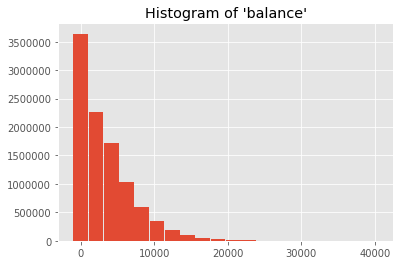

In [37]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}

plt.bar(data['bins'], data['freq'], width=2000)
plt.title('Histogram of \'balance\'')
plt.savefig('data/chapter4-01.png', dpi=300)

In a similar manner, a histogram can be created with Bokeh:

In [38]:
#No longer Valid 
#b_hist = chrt.Bar(
#    data,
#    values='freq', label='bins',
#    title='Histogram of \'balance\'')
#chrt.show(b_hist)

If your data is small enough to fit on the driver (although we would argue it would normally be faster to use the previous method), you can bring the data and use the `.hist(...)` (from matplotlib) or `.Histogram(...)` (from Bokeh) methods:

Text(0.5, 1.0, "Histogram of 'balance' using .hist()")

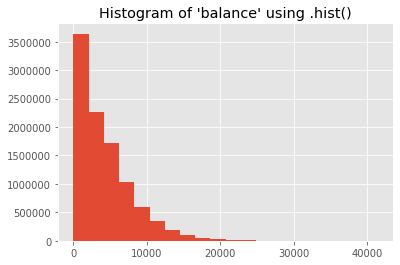

In [39]:
data_driver = {'obs': fraud_df.select('balance').rdd.flatMap(lambda row: row).collect()}
plt.hist(data_driver['obs'], bins=20)
plt.title('Histogram of \'balance\' using .hist()')

#b_hist_driver = chrt.Histogram(
#    data_driver, values='obs',
#    title='Histogram of \'balance\' using .Histogram()',
#    bins=20
#)
#chrt.show(b_hist_driver)

#### Interactions between features

Scatter charts allow us to visualize interactions between up to three variables at a time (although we will be only presenting a 2D interaction in this section).

Since PySpark does not offer any visualization modules on the server side, and trying to plot billions of observations at the same time would be highly impractical, in this section we will sample the dataset at 0.02% (roughly 2,000 observations).

In [40]:
data_sample = fraud_df.sampleBy('gender', {1: 0.0002, 2: 0.0002}).select(numerical)

In [42]:
data_multi = dict([
    (elem, data_sample.select(elem).rdd.flatMap(lambda row: row).collect()) 
    for elem in numerical
])

#sctr = chrt.Scatter(data_multi, x='balance', y='numTrans')
#chrt.show(sctr)

## Summary

In this chapter, we looked at how to clean and prepare your dataset for modeling by identifying and tackling datasets with missing values, duplicates, and outliers. We also looked at how to get a bit more familiar with your data using tools from PySpark (although this is by no means a full manual on how to analyze your datasets). Finally, we showed you how to chart your data.